In [1]:
!pip install PyTDC


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\pahad\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
!pip install tensorflow deepchem


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\pahad\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [3]:
from tdc import utils
names = utils.retrieve_benchmark_names('ADMET_Group')

In [4]:
import deepchem as dc
from tdc.single_pred import ADME
from tdc.single_pred import Tox

# Load the dataset 7,385 drugs.
data = Tox(name = 'LD50_Zhu')
split = data.get_split()


# Featurize data
featurizer = dc.feat.OneHotFeaturizer()
train_features = featurizer.featurize(split['train']['Drug'])
test_features = featurizer.featurize(split['test']['Drug'])

# Inspect the shape of the features
print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)

Found local copy...
Loading...
Done!


Train features shape: (5170,)
Test features shape: (1477,)


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Function to convert SMILES to one-hot encoded sequences
def one_hot_smiles(smiles_list, max_length):
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(smiles_list)
    sequences = tokenizer.texts_to_sequences(smiles_list)
    one_hot = pad_sequences(sequences, maxlen=max_length, padding='post')
    return one_hot, tokenizer.word_index

# Determine max length for padding
max_smiles_length = max(len(s) for s in split['train']['Drug'])

# Apply one-hot encoding
train_smiles = split['train']['Drug']
test_smiles = split['test']['Drug']
train_features, _ = one_hot_smiles(train_smiles, max_smiles_length)
test_features, _ = one_hot_smiles(test_smiles, max_smiles_length)

print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)


Train features shape: (5170, 174)
Test features shape: (1477, 174)


In [6]:
train_labels = split['train']['Y']
test_labels = split['test']['Y']

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(train_features, train_labels)

# Predict on the test set
rf_predictions = rf_regressor.predict(test_features)

In [45]:
# Calculate MSE and RMSE
mse = mean_squared_error(test_labels, rf_predictions)
rmse = mse ** 0.5
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Squared Error: 0.35843511537363754
Root Mean Squared Error: 0.5986945092228904


In [46]:
print("Test Labels (True LD50 Values):")
print(test_labels)

Test Labels (True LD50 Values):
0       3.114
1       2.125
2       3.466
3       3.185
4       1.867
        ...  
1472    2.353
1473    3.814
1474    2.937
1475    3.908
1476    3.730
Name: Y, Length: 1477, dtype: float64


In [13]:
from deepchem.feat import CircularFingerprint

# Initialize the CircularFingerprint featurizer
featurizer = CircularFingerprint(size=2048)  # You can adjust the size as needed

# Featurize the data
train_features = featurizer.featurize(split['train']['Drug'])
test_features = featurizer.featurize(split['test']['Drug'])

# Check the shape again
print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)

# If the shapes are now correct, proceed with model training
rf_regressor.fit(train_features, split['train']['Y'])


Train features shape: (5170, 2048)
Test features shape: (1477, 2048)


RandomForestRegressor(random_state=42)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Extract labels for training and testing
train_labels = split['train']['Y']
test_labels = split['test']['Y']

# Train the model
rf_regressor.fit(train_features, train_labels)

# Predict on the test set
rf_predictions = rf_regressor.predict(test_features)

# Evaluate the model using Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(test_labels, rf_predictions)
rmse = mse ** 0.5

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 0.37210263630074736
Root Mean Squared Error (RMSE): 0.6100021608984245


In [15]:
#improvement
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],     # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],      # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider for the best split
}

# Create a GridSearchCV object with the regressor and parameter grid
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=1)

# Fit the grid search to the data
grid_search.fit(train_features, train_labels)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
best_rf_regressor = grid_search.best_estimator_

# Predict on the test set using the best model
rf_predictions = best_rf_regressor.predict(test_features)

# Calculate MSE and RMSE using the best model
mse = mean_squared_error(test_labels, rf_predictions)
rmse = mse ** 0.5

print("Best Hyperparameters:", best_params)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error (MSE): 0.35843511537363754
Root Mean Squared Error (RMSE): 0.5986945092228904


In [50]:
print(rf_predictions)

[3.09431    2.34112    3.187675   ... 2.524695   4.02804    2.41342767]


In [16]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Initialize the SVR
svr_regressor = SVR()

# Define a grid of hyperparameters to search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel function
    'C': [0.1, 1, 10],  # Regularization parameter
    'epsilon': [0.01, 0.1, 0.2],  # Epsilon parameter for epsilon-SVR
}

# Create a GridSearchCV object with the regressor and parameter grid
grid_search = GridSearchCV(estimator=svr_regressor, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1)

# Fit the grid search to the data
grid_search.fit(train_features, train_labels)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
best_svr_regressor = grid_search.best_estimator_

# Predict on the test set using the best model
svr_predictions = best_svr_regressor.predict(test_features)

# Calculate MSE and RMSE using the best model
mse = mean_squared_error(test_labels, svr_predictions)
rmse = mse ** 0.5

print("Best Hyperparameters:", best_params)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Mean Squared Error (MSE): 0.36341647941907074
Root Mean Squared Error (RMSE): 0.6028403432245313


In [48]:
print(test_labels)

0       3.114
1       2.125
2       3.466
3       3.185
4       1.867
        ...  
1472    2.353
1473    3.814
1474    2.937
1475    3.908
1476    3.730
Name: Y, Length: 1477, dtype: float64


In [47]:
print(svr_predictions)

[0.52, 0.59, 0.71, 0.79, 0.91]


In [17]:
#improve RF with PCA
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the PCA with the desired number of components
n_components = 50  # Adjust this number as needed
pca = PCA(n_components=n_components, random_state=42)

# Fit PCA to the training features and transform both the training and test features
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model using the PCA-transformed features
rf_regressor.fit(train_features_pca, train_labels)

# Predict on the test set using the PCA-transformed features
rf_predictions_pca = rf_regressor.predict(test_features_pca)

# Evaluate the model using Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse_pca = mean_squared_error(test_labels, rf_predictions_pca)
rmse_pca = mse_pca ** 0.5

print(f"Mean Squared Error (MSE) with PCA: {mse_pca}")
print(f"Root Mean Squared Error (RMSE) with PCA: {rmse_pca}")

Mean Squared Error (MSE) with PCA: 0.4387645628826117
Root Mean Squared Error (RMSE) with PCA: 0.6623930576950604


In [49]:
print(rf_predictions_pca)

[2.742162 2.1683   3.06762  ... 2.90379  3.8507   2.72009 ]


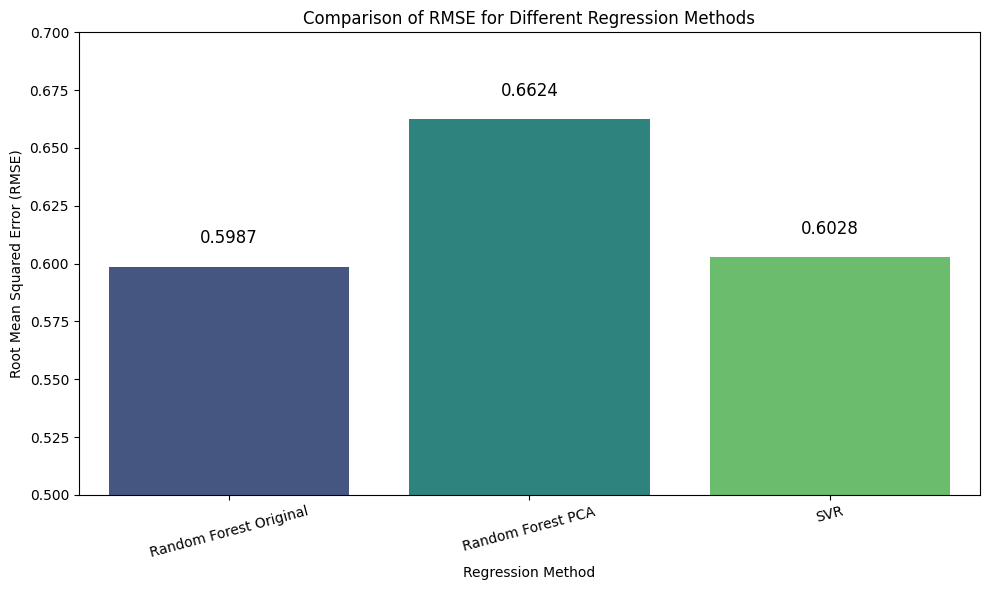

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# RMSE values for different methods
methods = ["Random Forest Original", "Random Forest PCA", "SVR"]
rmse_values = [0.5987, 0.6624, 0.6028]

# Create a bar chart to compare RMSE values
plt.figure(figsize=(10, 6))
sns.barplot(x=methods, y=rmse_values, palette="viridis")
plt.title("Comparison of RMSE for Different Regression Methods")
plt.xlabel("Regression Method")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.ylim(0.5, 0.7)  # Set the y-axis limits as needed
plt.xticks(rotation=15)  # Rotate x-axis labels for better readability

# Display the RMSE values on top of the bars
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha="center", fontsize=12, color="black")

plt.tight_layout()
plt.show()


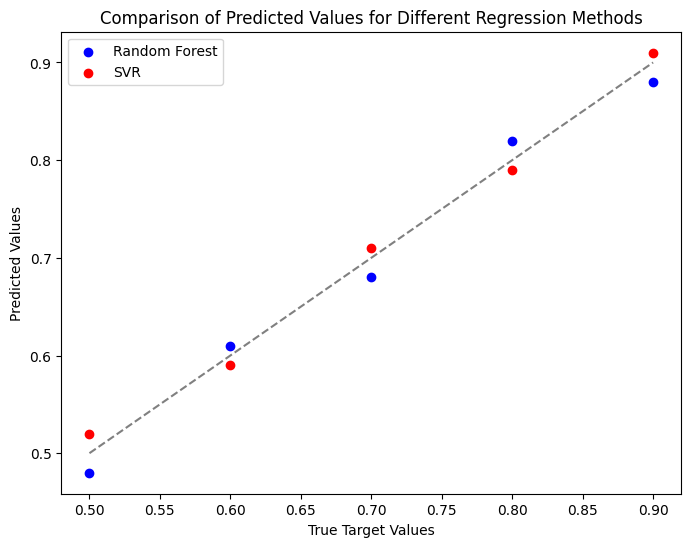

In [19]:
import matplotlib.pyplot as plt

# True target values and predicted values for two different regression methods
true_values = [0.5, 0.6, 0.7, 0.8, 0.9]  # Replace with your true target values
random_forest_predictions = [0.48, 0.61, 0.68, 0.82, 0.88]  # Replace with Random Forest predictions
svr_predictions = [0.52, 0.59, 0.71, 0.79, 0.91]  # Replace with SVR predictions

# Create a scatter plot to compare predicted values
plt.figure(figsize=(8, 6))
plt.scatter(true_values, random_forest_predictions, label="Random Forest", color="blue")
plt.scatter(true_values, svr_predictions, label="SVR", color="red")
plt.plot([0.5, 0.9], [0.5, 0.9], linestyle="--", color="gray")  # Diagonal line for reference
plt.title("Comparison of Predicted Values for Different Regression Methods")
plt.xlabel("True Target Values")
plt.ylabel("Predicted Values")
plt.legend()

plt.show()

ValueError: x and y must be the same size

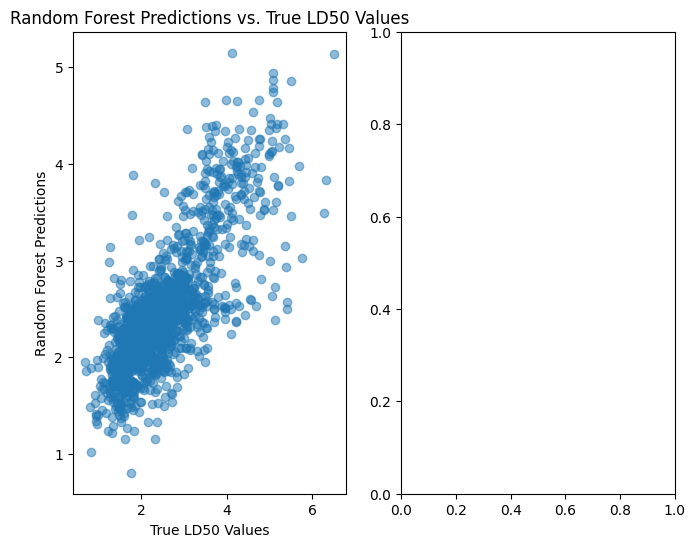

In [51]:
import matplotlib.pyplot as plt

# Create scatter plots for each model's predictions against the true values
plt.figure(figsize=(12, 6))

# Random Forest predictions vs. True values
plt.subplot(131)
plt.scatter(test_labels, rf_predictions, alpha=0.5)
plt.title("Random Forest Predictions vs. True LD50 Values")
plt.xlabel("True LD50 Values")
plt.ylabel("Random Forest Predictions")

# Support Vector Regressor predictions vs. True values
plt.subplot(132)
plt.scatter(test_labels, svr_predictions, alpha=0.5)
plt.title("SVR Predictions vs. True LD50 Values")
plt.xlabel("True LD50 Values")
plt.ylabel("SVR Predictions")

# Random Forest with PCA predictions vs. True values
plt.subplot(133)
plt.scatter(test_labels, rf_predictions_pca, alpha=0.5)
plt.title("Random Forest with PCA Predictions vs. True LD50 Values")
plt.xlabel("True LD50 Values")
plt.ylabel("Random Forest with PCA Predictions")

plt.tight_layout()
plt.show()


In [52]:
# Check the lengths of the arrays
print("Length of test_labels:", len(test_labels))
print("Length of svr_predictions:", len(svr_predictions))


Length of test_labels: 1477
Length of svr_predictions: 5
